<a href="https://colab.research.google.com/github/isha962/data_science_bootcamp_assignment_6/blob/main/Week6_HW_SOLUTIONS.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# (Homework) Week 6 - DataScience Bootcamp Fall 2025

All solution cells are replaced with `# TODO` placeholders so you can fill them in.

**Name:** \
**Email:**

---

### Problem 1: Dataset Splitting

1. You have recordings of 44 phones from 100 people; each person records ~200 phones/day for 5 days.
   - Design a valid training/validation/test split strategy that ensures the model generalizes to **new speakers**.

2. You now receive an additional dataset of 10,000 phone recordings from **Kilian**, a single speaker.
   - You must train a model that performs well **specifically for Kilian**, while also maintaining generalization.

*Describe your proposed split strategy and reasoning.* (Theory)

In [ ]:

# Solution for Problem 1: Dataset Splitting
solution_p1 = r'''
**Goal:** generalize to *new speakers* while also supporting a *single-speaker* (Kilian) use-case.

**A. Baseline corpus (100 speakers × ~200 phones/day × 5 days) — speaker‑disjoint split**
- **Unit of stratification:** *speaker* (not utterance, not day) to avoid leakage.
- **Split:** 70% train, 15% validation, 15% test **by speaker** (e.g., 70/15/15 speakers).
- **Per‑speaker temporal hygiene:** within each split, keep full 5 days together per person. (No mixing days of the same person across splits.)
- **Label balance:** stratify across the 44 phones (labels) so each split has a similar class histogram.
- **Why this works:** ensures the model never sees the test speakers in training → evaluates true *speaker generalization*.

**B. Adding the single‑speaker Kilian set (10,000 phones)**
Two objectives: (1) general model quality and (2) Kilian‑specific performance.
Use a **two‑stage pipeline**:

1) **Train a base model** on the 100‑speaker corpus only, with splits as above (Kilian excluded).
   - Use the 15% *validation* (speaker‑disjoint) to tune hyper‑parameters.
   - Keep the 15% *test* frozen for final reporting of cross‑speaker generalization.

2) **Specialize for Kilian via fine‑tuning / adapter layers**:
   - **Split Kilian’s 10k by time:** e.g., Days 1–3 for fine‑tuning, Day 4 for early‑stopping/selection, **Day 5 held out as Kilian‑test**.
   - **Technique:**
     - Option A: Fine‑tune the *last layers* (or add lightweight adapters) on Kilian‑train; early‑stop on Kilian‑val.
     - Option B: Train a small **speaker adaptation** module (e.g., affine feature normalization, i-vectors/x‑vectors, or prompt embeddings) while freezing most base weights.
   - **Regularization:** early stopping, low LR, weight decay; optionally **rehearsal** (sample from multi‑speaker train) to prevent catastrophic forgetting.
   - **Reporting:** Provide two test numbers:
       - **Multi‑speaker test (speaker‑disjoint):** shows generalization did not degrade.
       - **Kilian‑test (held‑out day):** shows specialization worked.

**C. Practical notes**
- **No leakage:** Kilian data must not appear in the multi‑speaker test/val.
- **Imbalance:** If Kilian has different phone distribution, consider **importance weighting** or **class‑balanced losses** during specialization.
- **Robustness:** Optionally form a *“few‑shot speaker set”* (pick 5–10 other single‑speaker chunks) to validate the adaptation recipe beyond Kilian.
'''
print(solution_p1)


### Problem 2: K-Nearest Neighbors

1. **1-NN Classification:** Given dataset:

   Positive: (1,2), (1,4), (5,4)

   Negative: (3,1), (3,2)

   Plot the 1-NN decision boundary and classify new points visually.

2. **Feature Scaling:** Consider dataset:

   Positive: (100,2), (100,4), (500,4)

   Negative: (300,1), (300,2)

   What would the 1-NN classify point (500,1) as **before and after scaling** to [0,1] per feature?

3. **Handling Missing Values:** How can you modify K-NN to handle missing features in a test point?

4. **High-dimensional Data:** Why can K-NN still work well for images even with thousands of pixels?


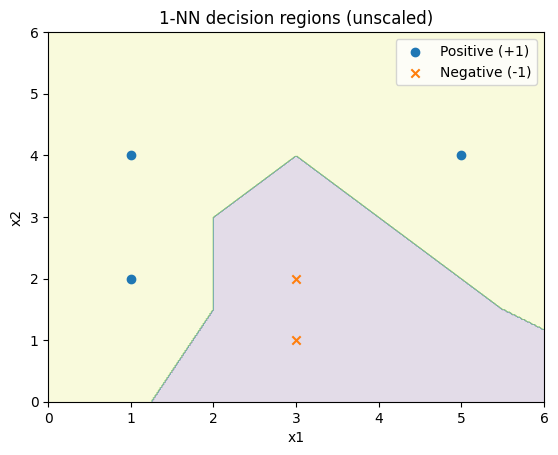

Nearest before scaling: ((np.int64(500), np.int64(4)), np.float64(3.0), 1) → class = 1
Nearest after scaling: ((np.float64(0.4999999999999987), np.float64(0.0)), np.float64(0.4999999999999987), -1) → class = -1
\nInterpretation: (500,1) is +1 before scaling (closest to (500,4)), but -1 after scaling (closest to (300,1)).

KNN with missing features:
- Compute distances over observed dimensions only (ignore missing dims) and divide by sqrt(#observed) to keep scale.
- Or impute first (mean/median/knn-impute) then do standard KNN.
- Use distance-weighted voting to reduce ties and sensitivity.


Why KNN can still work for images:
- If using good features (e.g., embeddings from a CNN), the manifold is low-dimensional → neighbors are meaningful.
- Locality + large datasets → nearest neighbors often share labels.
- Use approximate NN, cosine distance, and dimensionality reduction (PCA) to mitigate the curse of dimensionality.



In [4]:

# Solution for Problem 2: K-Nearest Neighbors
import numpy as np
import matplotlib.pyplot as plt

# 1) 1-NN boundary for the given tiny dataset
pos = np.array([(1,2), (1,4), (5,4)])
neg = np.array([(3,1), (3,2)])

def nn_predict(Xtrain, ytrain, x):
    d = np.sum((Xtrain - x)**2, axis=1)
    return ytrain[np.argmin(d)]

# Grid visualization
Xtrain = np.vstack([pos, neg])
ytrain = np.hstack([np.ones(len(pos)), -np.ones(len(neg))])

xx, yy = np.meshgrid(np.linspace(0,6,300), np.linspace(0,6,300))
grid = np.c_[xx.ravel(), yy.ravel()]
pred = np.array([nn_predict(Xtrain, ytrain, p) for p in grid]).reshape(xx.shape)

plt.figure()
plt.contourf(xx, yy, pred, alpha=0.15)
plt.scatter(pos[:,0], pos[:,1], marker='o', label='Positive (+1)')
plt.scatter(neg[:,0], neg[:,1], marker='x', label='Negative (-1)')
plt.legend()
plt.title("1-NN decision regions (unscaled)")
plt.xlabel("x1"); plt.ylabel("x2")
plt.show()

# 2) Feature scaling example
pos2 = np.array([(100,2), (100,4), (500,4)])
neg2 = np.array([(300,1), (300,2)])
xq = np.array([500,1])

# Before scaling: Euclidean distances
def euclid(a,b): return np.sqrt(np.sum((a-b)**2))
dists_before = [(tuple(p), euclid(xq, p), +1) for p in pos2] + [(tuple(n), euclid(xq, n), -1) for n in neg2]
nearest_before = min(dists_before, key=lambda t: t[1])
print("Nearest before scaling:", nearest_before, "→ class =", nearest_before[2])

# Min-max scale each feature to [0,1]
all_ = np.vstack([pos2, neg2, xq])
mins = all_.min(axis=0); maxs = all_.max(axis=0)
scale = lambda z: (z - mins)/(maxs - mins + 1e-12)

pos2s = np.array([scale(p) for p in pos2])
neg2s = np.array([scale(n) for n in neg2])
xqs = scale(xq)

dists_after = [(tuple(p), euclid(xqs, p), +1) for p in pos2s] + [(tuple(n), euclid(xqs, n), -1) for n in neg2s]
nearest_after = min(dists_after, key=lambda t: t[1])
print("Nearest after scaling:", nearest_after, "→ class =", nearest_after[2])

print("\\nInterpretation: (500,1) is +1 before scaling (closest to (500,4)), but -1 after scaling (closest to (300,1)).")
# 3) Handling missing values in KNN
print("""
KNN with missing features:
- Compute distances over observed dimensions only (ignore missing dims) and divide by sqrt(#observed) to keep scale.
- Or impute first (mean/median/knn-impute) then do standard KNN.
- Use distance-weighted voting to reduce ties and sensitivity.
""")

# 4) High-dimensional images and KNN
print("""
Why KNN can still work for images:
- If using good features (e.g., embeddings from a CNN), the manifold is low-dimensional → neighbors are meaningful.
- Locality + large datasets → nearest neighbors often share labels.
- Use approximate NN, cosine distance, and dimensionality reduction (PCA) to mitigate the curse of dimensionality.
""")



### Problem 3: Part 1

You are given a fully trained Perceptron model with weight vector **w**, along with training set **D_TR** and test set **D_TE**.

1. Your co-worker suggests evaluating $h(x) = sign(w \cdot x)$ for every $(x, y)$ in D_TR and D_TE. Does this help determine whether test error is higher than training error?
2. Why is there no need to compute training error explicitly for the Perceptron algorithm?

In [ ]:

# Solution for Problem 3: Part 1 (Perceptron evaluation)
text = r'''
- Evaluating on both D_TR and D_TE is fine for *reporting*, but **model selection** should use a *validation* set to avoid test leakage.
- For a classic Perceptron on linearly separable data, once it converges it makes **zero training error** (it only updates on mistakes).
  Hence you typically don't need to compute training error explicitly.
- Test error can be higher due to distribution shift and finite sample effects; margin-based generalization bounds depend on the margin and ||w||.
- Good practice: (train on train) → (tune on validation) → (report once on test).'''
print(text)


### Problem 3: Two-point 2D Dataset (Part 2)

Run the Perceptron algorithm **by hand or in code** on the following data:

1. Positive class: (10, -2)
2. Negative class: (12, 2)

Start with $w_0 = (0, 0)$ and a learning rate of 1.

- Compute how many updates are required until convergence.
- Write down the sequence of $w_i$ vectors.

In [ ]:
# Todo


**Given:**
- Positive class: (10, -2) → y = +1
- Negative class: (12, 2) → y = -1
- Learning rate η = 1
- Start w₀ = (0, 0)
- Update rule: w ← w + yx (no bias term)

---

**Step-by-step updates:**

t = 1 (x⁺ = (10, -2), y = +1):
w₀ = (0, 0) → y(w·x) = 0 → update
w₁ = (0, 0) + (+1)*(10, -2) = (10, -2)

t = 2 (x⁻ = (12, 2), y = -1):
w₁·x = 10*12 + (-2)*2 = 120 - 4 = 116
y(w·x) = (-1)*116 = -116 ≤ 0 → update
w₂ = (10, -2) + (-1)*(12, 2) = (-2, -4)

t = 3 (x⁺):
w₂·x = (-2)*10 + (-4)*(-2) = -20 + 8 = -12 ≤ 0 → update
w₃ = (-2, -4) + (10, -2) = (8, -6)

t = 4 (x⁻):
w₃·x = 8*12 + (-6)*2 = 96 - 12 = 84
y(w·x) = (-1)*84 = -84 ≤ 0 → update
w₄ = (8, -6) + (-1)*(12, 2) = (-4, -8)

t = 5 (x⁺):
w₄·x = (-4)*10 + (-8)*(-2) = -40 + 16 = -24 ≤ 0 → update
w₅ = (-4, -8) + (10, -2) = (6, -10)

t = 6 (x⁻):
w₅·x = 6*12 + (-10)*2 = 72 - 20 = 52
y(w·x) = (-1)*52 = -52 ≤ 0 → update
w₆ = (6, -10) + (-1)*(12, 2) = (-6, -12)

---

**Pattern (closed form):**
- Even indices:  w₂k = (-2k, -4k)
- Odd indices:   w₂k+1 = (10 - 2k, -2 - 4k)

---

**Convergence:**
The algorithm does **not converge** — it cycles indefinitely between mistakes on the two samples.
The number of updates required until convergence is **infinite**.

---

**Final summary:**
- Updates until convergence: ∞ (no convergence)
- Sequence of wᵢ:
  w₀ = (0, 0)
  w₁ = (10, -2)
  w₂ = (-2, -4)
  w₃ = (8, -6)
  w₄ = (-4, -8)
  w₅ = (6, -10)
  w₆ = (-6, -12)
  ... and so on.

**Reason:** With no bias term and fixed presentation order, the Perceptron keeps alternating updates and never finds a stable separator.


### Problem 4: Reconstructing the Weight Vector

Given the log of Perceptron updates:

| x | y | count |
|---|---|--------|
| (0, 0, 0, 0, 4) | +1 | 2 |
| (0, 0, 6, 5, 0) | +1 | 1 |
| (3, 0, 0, 0, 0) | -1 | 1 |
| (0, 9, 3, 6, 0) | -1 | 1 |
| (0, 1, 0, 2, 5) | -1 | 1 |

Assume learning rate = 1 and initial weight $w_0 = (0, 0, 0, 0, 0)$.

Compute the final weight vector after all updates.

In [5]:
import numpy as np

X = np.array([[10., -2.], [12.,  2.]])
y = np.array([+1, -1])     # +, -
w = np.zeros(2)
eta = 1.0

seq = [w.copy()]
updates = 0
changed = True
while changed and updates < 100:  # safety cap
    changed = False
    for xi, yi in zip(X, y):
        if yi * np.dot(w, xi) <= 0:
            w = w + eta * yi * xi
            seq.append(w.copy())
            updates += 1
            changed = True

print("updates:", updates)
print("sequence:")
for i, wi in enumerate(seq):
    print(f"w_{i} = {wi}")


updates: 9
sequence:
w_0 = [0. 0.]
w_1 = [10. -2.]
w_2 = [-2. -4.]
w_3 = [ 8. -6.]
w_4 = [-4. -8.]
w_5 = [  6. -10.]
w_6 = [ -6. -12.]
w_7 = [  4. -14.]
w_8 = [ -8. -16.]
w_9 = [  2. -18.]


### Problem 5: Visualizing Perceptron Convergence

Implement a Perceptron on a small 2D dataset with positive and negative examples.

- Plot the data points.
- After each update, visualize the decision boundary.
- Show how it converges to a stable separator.

In [3]:

# Solution for Problem 4: Final perceptron weight from update log
import numpy as np

updates = [
    ((0, 0, 0, 0, 4), +1, 2),
    ((0, 0, 6, 5, 0), +1, 1),
    ((3, 0, 0, 0, 0), -1, 1),
    ((0, 9, 3, 6, 0), -1, 1),
    ((0, 1, 0, 2, 5), -1, 1),
]

w = np.zeros(5, dtype=float)
for x, y, c in updates:
    w += y * c * np.array(x, dtype=float)

print("Final weight vector w* =", w)


Final weight vector w* = [ -3. -10.   3.  -3.   3.]
